# Short analysis of the FG matrix with the oslo method:
## Goal: Find out whether we get an "artificial" upbent

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import logging

In [3]:
om.__full_version__

'0.8.0.dev0+06fb182'

### Load matrix

<IPython.core.display.Javascript object>


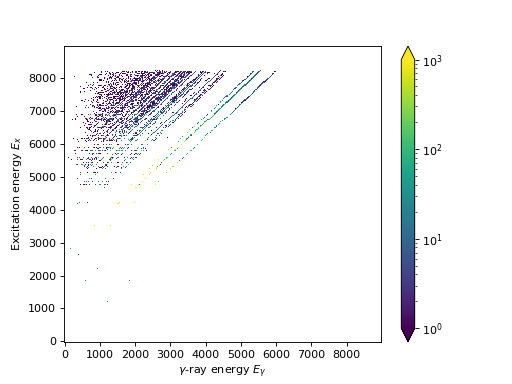

(<matplotlib.collections.QuadMesh at 0x7f819bdee9b0>,
 <Figure size 640x480 with 2 Axes>)

In [4]:
fg = om.Matrix(path="1Gen.m")
fg.plot(vmin=1, vmax=1e3)

 Apply some smoothing, such that the data resembles something we would get from an experiment

<IPython.core.display.Javascript object>


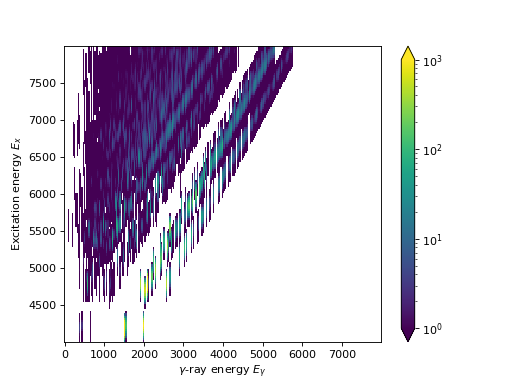

(<matplotlib.collections.QuadMesh at 0x7f819be6b278>,
 <Figure size 640x480 with 2 Axes>)

In [5]:
fg.cut(axis="Ex", Emin=4000, Emax=8000)
fg.cut(axis="Eg", Emin=0, Emax=8000)
# "particle" resolution
fg.values = om.gauss_smoothing_matrix_1D(fg.values, fg.Ex, fwhm=100., axis="Ex")
# simplified gamma-resolution
fg.values = om.gauss_smoothing_matrix_1D(fg.values, fg.Ex, fwhm=100., axis="Ex")
fg.plot(vmin=1, vmax=1e3)

Rebin for the later analysis

<IPython.core.display.Javascript object>


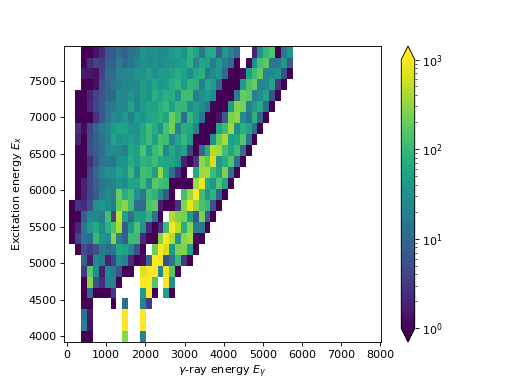

(<matplotlib.collections.QuadMesh at 0x7f819bee3da0>,
 <Figure size 640x480 with 2 Axes>)

In [6]:
E = np.arange(0, 8000, 150.)
fg.rebin(axis="Eg", edges=E)
E = np.arange(4000, 8000, 150.)
fg.rebin(axis="Ex", edges=E)
fg.plot(vmin=1, vmax=1e3)

Perform the decomposition on with a given "cut".
I chose not to extend the analysis beyond $Ex=Eg$, but rather rebinned with ~FWHM.

We chose rather low Ex limit given how the FG looks like. There is also some bump in the matrix around $Ex = 5.5 MeV$. Further down, I will vary `Ex_min` to see the effect.

In [7]:
trapezoid_cut = om.Action('matrix')
trapezoid_cut.trapezoid(Ex_min=4800, Ex_max=7000, Eg_min=1000, inplace=False)
extractor = om.Extractor()
extractor.extend_fit_by_resolution = False

# assume that the std is given by sqrt(N) for the fg
fg_in = trapezoid_cut.act_on(fg)[0]
std = fg_in.copy()
std.values = np.sqrt(std.values)

nld, gsf, product = extractor.decompose(fg_in, std=std, product=True)

Comparison of the FG matrix and the fit

<IPython.core.display.Javascript object>


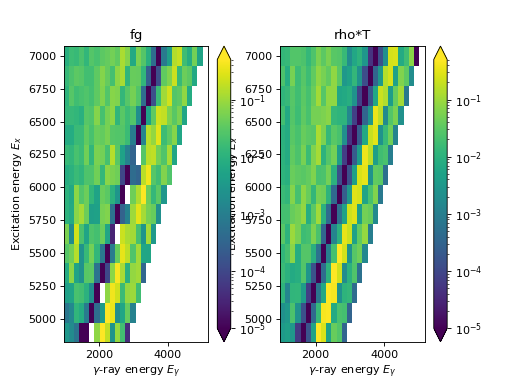

(<matplotlib.collections.QuadMesh at 0x7f819b980908>,
 <Figure size 640x480 with 4 Axes>)

In [8]:
fg_in.values = om.normalize_rows(fg_in.values)
fig, ax = plt.subplots(1,2)
fg_in.plot(ax=ax[0], scale="log", vmin=1e-5, vmax=5e-1, title="fg")
product.plot(ax=ax[1], scale="log", vmin=1e-5, vmax=5e-1, title="rho*T")

As we're for now just interested in seeing whether there is an aritificial upbend at low energies. Therefore I don't do a proper normalization, but just see how the gsf looks like if I have a *reasonable* slope on the NLD. By reasonable I mean something that looks like in the paper...

<IPython.core.display.Javascript object>


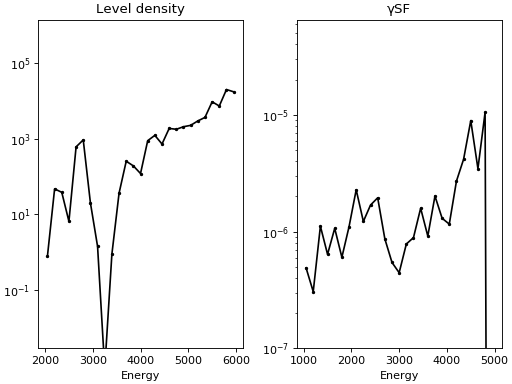

interactive(children=(SelectionSlider(description='alpha', index=25, options=(('1.00e-04', 0.0001), ('1.10e-04…

<function __main__.plot_transformed(alpha, A=1.0, B=1.0)>

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual, SelectionSlider
import ipywidgets as widgets

fig, ax = plt.subplots(1, 2, constrained_layout=True)
nld.transform(const=1, alpha=0.0015, inplace=False).plot(ax=ax[0], scale="log", color='k')
gsf.transform(const=1, alpha=0.0015, inplace=False).plot(ax=ax[1], scale="log", color='k')
ylim0 = ax[0].get_ylim()
xlim0 = ax[0].get_xlim()
ylim1 = 1e-7#ax[1].get_ylim()
xlim1 = ax[1].get_xlim()

def plot_transformed(alpha, A=1., B=1.):
    ax[0].cla()
    ax[1].cla()
    nld.transform(const=A, alpha=alpha, inplace=False).plot(ax=ax[0], scale="log", color='k')
    gsf.transform(const=B, alpha=alpha, inplace=False).plot(ax=ax[1], scale="log", color='k')
    ax[0].set_title("Level density")
    ax[1].set_title("γSF")
    ax[0].set_ylim(ylim0)
    ax[1].set_ylim(ylim1)
    ax[0].set_xlim(xlim0)
    ax[1].set_xlim(xlim1)

    
values = np.logspace(-4, -2)
slider = SelectionSlider(options=[(f"{i:.2e}",i) for i in values], index=25)

interact(plot_transformed, alpha=slider, A=0.5)
# plot_transformed(alpha=0.0015)

Does it look a little strange? Well, let's see the effect of choosing a different lower Ex limit `Ex_min` for the extraction: 

In [10]:
Ex_min = np.linspace(4800, 6200, num=5)

nlds = []
gsfs = []

for E in Ex_min:
    trapezoid_cut = om.Action('matrix')
    trapezoid_cut.trapezoid(Ex_min=E, Ex_max=7000, Eg_min=1000, inplace=False)

    # assume that the std is given by sqrt(N) for the fg
    fg_in = trapezoid_cut.act_on(fg)[0]
    std = fg_in.copy()
    std.values = np.sqrt(std.values)

    nld, gsf, product = extractor.decompose(fg_in, std=std, product=True)
    nlds.append(nld)
    gsfs.append(gsf)

In [11]:
KX1 = 8.673592583E-08 #; // mb^-1 MeV^-2;  = 1/(3*(pi*hbar*c)^2)
def lorentzian_RAINIER( x, x0, sig, gam ):
    return KX1 * sig * gam**2 / ((x * gam)**2 + ( x**2 - x0**2 )**2)

<IPython.core.display.Javascript object>


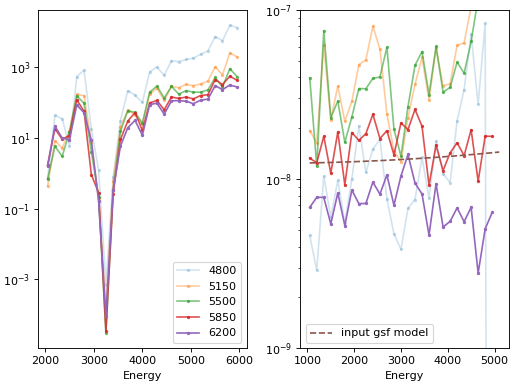

In [12]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

for i, (nld_in, gsf_in) in enumerate(list(zip(nlds, gsfs))):
    nld = nld_in.transform(const=0.5, alpha=1e-3, inplace=False)
    gsf = gsf_in.transform(const=1e-2, alpha=1e-3, inplace=False)
    nld.plot(ax=ax[0], scale="log", label=f"{Ex_min[i]:.0f}", alpha=1/len(nlds)*(i+1))
    gsf.plot(ax=ax[1], scale="log", alpha=1/len(nlds)*(i+1))
ax[1].set_ylim(1e-9, 1e-7)

x = gsf.E
pars = {"sig": 190.00, "x0": 17.50, "gam": 8.40}
ax[1].plot(x, lorentzian_RAINIER(x/1000, **pars), "--", label="input gsf model")

ax[0].legend()
ax[1].legend()

I don't see any upbend like structure here